In [1]:
from sklearn.model_selection import train_test_split
from cnn import ChessDataset, ChessEvaluationConvolutionalNetwork, ConvolutionInputModel
from torch.utils.data import DataLoader
import torch
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('../../data/chess_data.csv')
df = df[~df['Evaluation'].str.contains('#', na=False)]

df = df.reset_index(drop=True)


df['board_vec'] = df.apply(lambda row: ConvolutionInputModel.fen_to_feature_array(row['FEN'])[0].squeeze(0), axis=1)
df['meta_vec'] = df.apply(lambda row: ConvolutionInputModel.fen_to_feature_array(row['FEN'])[1].squeeze(0), axis=1)

X = df[['board_vec', 'meta_vec']]
df['Evaluation'] = pd.to_numeric(df['Evaluation'], errors='raise')
Y = (df['Evaluation'] - df['Evaluation'].min()) / (df['Evaluation'].max() - df['Evaluation'].min())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Convert to a column tensor
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = ChessDataset(X_train, y_train_tensor)
test_dataset = ChessDataset(X_test, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)



In [2]:
import torch.nn as nn
import torch.optim as optim

batch_size = 32
epochs = 10
lr = 0.001


model = ChessEvaluationConvolutionalNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []

for epoch in range(epochs):
    running_loss = 0
    model.train()

    for x_board, x_meta, target in train_loader:
        optimizer.zero_grad()
        output = model(x_board, x_meta)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.0020
Epoch 2/10, Loss: 0.0012
Epoch 3/10, Loss: 0.0010
Epoch 4/10, Loss: 0.0009
Epoch 5/10, Loss: 0.0007
Epoch 6/10, Loss: 0.0006
Epoch 7/10, Loss: 0.0006
Epoch 8/10, Loss: 0.0005
Epoch 9/10, Loss: 0.0005
Epoch 10/10, Loss: 0.0004


In [3]:
import numpy as np
model.eval()
test_loss = 0.0
with torch.no_grad():
    for x_board, x_meta, target in test_loader:
        outputs = model(x_board, x_meta)
        loss = criterion(outputs, target)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
rmse_error = np.sqrt(avg_test_loss)
print(f"\nTest RMSE: {rmse_error:.4f}")


Test RMSE: 0.0283


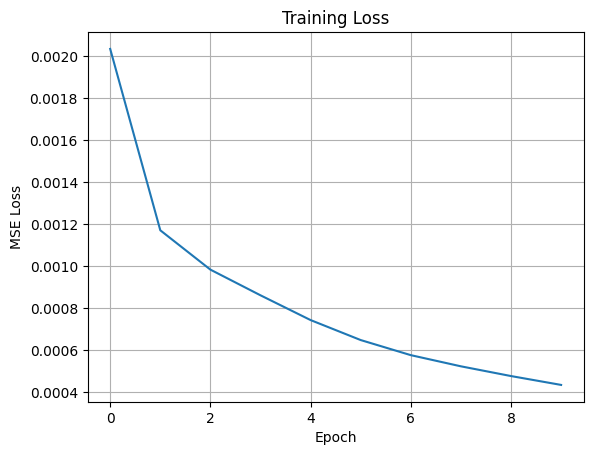

In [4]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.savefig("training_loss.png")

In [5]:
torch.save(model.state_dict(), 'convolutional_network.pth')